## imports

In [ ]:
!pip install -q datasets transformers peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 247.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyar

In [ ]:
from datasets import load_dataset
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import Trainer, TrainingArguments, pipeline
from huggingface_hub import notebook_login
from peft import LoraConfig, TaskType, get_peft_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import torch

## prepare dataset

In [ ]:
dataset = load_dataset("K-Monitor/kmdb_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/71483 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.map(lambda row: {'td': row['title']+'\n'+row['description']})
# dataset = dataset.map(lambda row: {'td': row['title']+'\n'+row['description']+'\n'+'\n'.join(row['text'].split('\n')[:10])})

Map:   0%|          | 0/71483 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.shuffle(seed=42)
split = dataset['train'].train_test_split(test_size=0.2, seed=42,)
dataset = split['test'].train_test_split(test_size=0.5, seed=42,)
dataset['validation'] = dataset['train']
dataset['train'] = split['train']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'description', 'keywords', 'label', 'url', 'date', 'is_hand_annoted', 'td'],
        num_rows: 57186
    })
    test: Dataset({
        features: ['text', 'title', 'description', 'keywords', 'label', 'url', 'date', 'is_hand_annoted', 'td'],
        num_rows: 7149
    })
    validation: Dataset({
        features: ['text', 'title', 'description', 'keywords', 'label', 'url', 'date', 'is_hand_annoted', 'td'],
        num_rows: 7148
    })
})

In [ ]:
tokenizer = BertTokenizer.from_pretrained('SZTAKI-HLT/hubert-base-cc')

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/272k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["td"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/57186 [00:00<?, ? examples/s]

Map:   0%|          | 0/7149 [00:00<?, ? examples/s]

Map:   0%|          | 0/7148 [00:00<?, ? examples/s]

## load model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'SZTAKI-HLT/hubert-base-cc',
    num_labels=2
)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=True,
    r=128,
    lora_alpha=128,
    lora_dropout=0.05,
    use_rslora=True,
    use_dora=True,
    bias="all",
    target_modules=["query", "key", "value",],
    modules_to_save=["classifier"],
)

In [ ]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 104,450 || all params: 117,726,724 || trainable%: 0.0887


## train

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, _, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall
    }

In [ ]:
batch_size=32

training_args = TrainingArguments(
    output_dir="hubert-classification",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=2,
    eval_steps=200,
    save_steps=20,
    save_total_limit=40,
    save_strategy='steps',
    evaluation_strategy='steps',
    learning_rate=0.002,
    warmup_steps=40,
    num_train_epochs=1,
)

trainer = Trainer(
    model=model,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    args=training_args,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall
20,0.491900,0.445411,0.824007,0.822625,0.854936
40,0.360400,0.289010,0.881365,0.869435,0.915423
60,0.245100,0.274218,0.890459,0.856505,0.954962
80,0.202800,0.287005,0.886402,0.839314,0.973815
100,0.226800,0.240275,0.902210,0.867405,0.964389
120,0.253900,0.220784,0.907946,0.892866,0.940560
140,0.223800,0.221930,0.907946,0.882966,0.954176
160,0.241200,0.224361,0.908086,0.877507,0.962294
180,0.215500,0.212963,0.910744,0.898921,0.938466
200,0.242500,0.221907,0.911304,0.881986,0.962817


TrainOutput(global_step=223, training_loss=0.2876475321738709, metrics={'train_runtime': 8227.8605, 'train_samples_per_second': 6.95, 'train_steps_per_second': 0.027, 'total_flos': 1.6266882312044544e+16, 'train_loss': 0.2876475321738709, 'epoch': 0.9977628635346756})

## evaluate

In [ ]:
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

{'eval_loss': 0.19159336388111115,
 'eval_accuracy': 0.922087005175549,
 'eval_precision': 0.9031452820768847,
 'eval_recall': 0.9553736466860312,
 'eval_runtime': 284.5888,
 'eval_samples_per_second': 25.12,
 'eval_steps_per_second': 0.787,
 'epoch': 0.9977628635346756}

In [ ]:
merged = model.merge_and_unload()

In [ ]:
classifier = pipeline("sentiment-analysis", model=merged, tokenizer=tokenizer, return_all_scores=True, max_length=512)
classifier('hello')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.8940171003341675},
  {'label': 'LABEL_1', 'score': 0.10598289966583252}]]

In [ ]:
dataset['test'] = dataset['test'].map(lambda row: {'score': classifier(row['td'])[0][1]['score']})

Map:   0%|          | 0/7149 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
precision, recall, thresholds = precision_recall_curve(dataset['test']['label'], dataset['test']['score'])

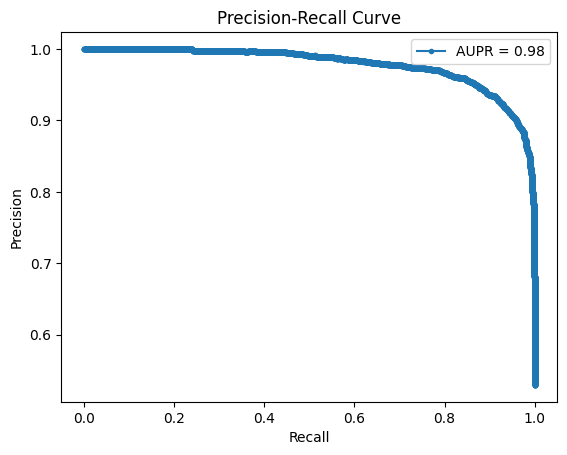

In [ ]:
aupr = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
aupr
# 0.9843052286062822
# 0.946710389734783
# 0.9865083235548402

0.97780423355173

## eval old

In [ ]:
merged = BertForSequenceClassification.from_pretrained('boapps/kmdb_classification_model')
tokenizer = BertTokenizer.from_pretrained('SZTAKI-HLT/hubert-base-cc')

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
classifier = pipeline("sentiment-analysis", model=merged, tokenizer=tokenizer, return_all_scores=True, max_length=512)
classifier('hello')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[[{'label': 'LABEL_0', 'score': 0.6168661713600159},
  {'label': 'LABEL_1', 'score': 0.38313382863998413}]]

In [ ]:
dataset['test'] = dataset['test'].map(lambda row: {'score': classifier(row['td'])[0][1]['score']})

Map:   0%|          | 0/7149 [00:00<?, ? examples/s]

In [ ]:
precision, recall, thresholds = precision_recall_curve(dataset['test']['label'], dataset['test']['score'])

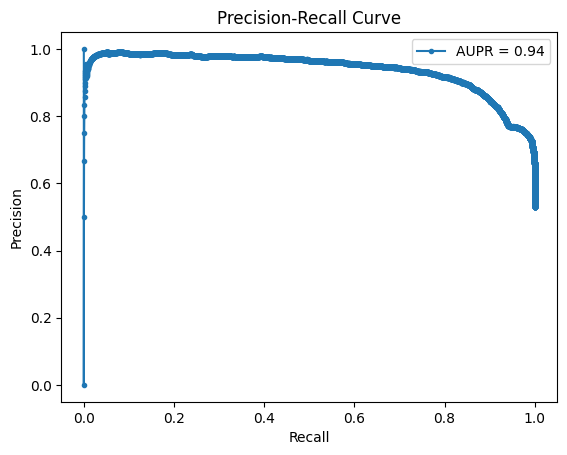

In [ ]:
aupr = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
aupr
# 0.9843052286062822
# 0.946710389734783
# 0.9865083235548402
# 0.9397254130747401

0.9397254130747401

## upload

In [ ]:
notebook_login()

In [ ]:
merged.push_to_hub('K-Monitor/kmdb_classification_hubert')

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/K-Monitor/kmdb_classification_hubert/commit/42ea77132946a4d3c9085a059d1fd668a1090750', commit_message='Upload BertForSequenceClassification', commit_description='', oid='42ea77132946a4d3c9085a059d1fd668a1090750', pr_url=None, pr_revision=None, pr_num=None)